### Import Libraries and Data

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os

### LOAD DATA
umsatz_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv"
wetter_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv"
kiwo_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv"

# Load external data
umsatz_df = pd.read_csv(umsatz_url)
wetter_df = pd.read_csv(wetter_url)
kiwo_df   = pd.read_csv(kiwo_url)
test_df   = pd.read_csv("test.csv",  parse_dates=["Datum"])

#print headers of the dataframes
print("Umsatz DataFrame:")
display(umsatz_df.head())
print("\nWetter DataFrame:")
display(wetter_df.head())
print("\nKiwo DataFrame:")
display(kiwo_df.head())
print("\nTest DataFrame:")
display(test_df.head())

Umsatz DataFrame:


,id,Datum,Warengruppe,Umsatz
0,1307011,2013-07-01,1,148.828353
1,1307021,2013-07-02,1,159.793757
2,1307031,2013-07-03,1,111.885594
3,1307041,2013-07-04,1,168.864941
4,1307051,2013-07-05,1,171.280754



Wetter DataFrame:


,Datum,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode
0,2012-01-01,8.0,9.8250,14,58.0
1,2012-01-02,7.0,7.4375,12,NaN
2,2012-01-03,8.0,5.5375,18,63.0
3,2012-01-04,4.0,5.6875,19,80.0
4,2012-01-05,6.0,5.3000,23,80.0



Kiwo DataFrame:


,Datum,KielerWoche
0,2012-06-16,1
1,2012-06-17,1
2,2012-06-18,1
3,2012-06-19,1
4,2012-06-20,1



Test DataFrame:


,id,Datum,Warengruppe
0,1808011,2018-08-01,1
1,1808021,2018-08-02,1
2,1808031,2018-08-03,1
3,1808041,2018-08-04,1
4,1808051,2018-08-05,1


### Merging Data

In [ ]:
### MERGE DATA
merged_df = pd.concat([umsatz_df, test_df], axis=0, ignore_index=True)
merged_df = pd.merge(merged_df, wetter_df, on="Datum", how="left")
merged_df = pd.merge(merged_df, kiwo_df, on="Datum", how="left")
merged_df = merged_df.sort_values('Datum')

#print headers of the dataframes
print("Merged DataFrame:")
display(merged_df.head())

### Data Cleaning + Imputing

In [ ]:
### MISSING VALUE HANDLING
merged_df = merged_df.set_index("Datum")
merged_df["Temperatur"] = merged_df["Temperatur"].interpolate(method="time")
merged_df["Windgeschwindigkeit"] = merged_df["Windgeschwindigkeit"].interpolate(method="time")
merged_df["Bewoelkung"] = merged_df["Bewoelkung"].interpolate(method="time")
merged_df["KielerWoche"] = merged_df["KielerWoche"].fillna(0)
merged_df["Wettercode"] = merged_df["Wettercode"].fillna(method="ffill").fillna(method="bfill")
merged_df = merged_df.reset_index()

### Data Preparation

In [ ]:
### DEFINE CATEGORICAL VARIABLES
wetter_dummies = pd.get_dummies(merged_df["Wettercode"].astype(int), prefix="WetterCode")
merged_df = pd.concat([merged_df, wetter_dummies], axis=1)

warengruppe_dummies = pd.get_dummies(merged_df["Warengruppe"], prefix="Warengruppe")
merged_df = pd.concat([merged_df, warengruppe_dummies], axis=1)

print("Merged DataFrame:")
display(merged_df.head())

In [ ]:
### COMBINE WARENGRUPPEN SALES
sales_daily_df = merged_df.groupby("Datum")["Umsatz"].sum().reset_index()
sales_daily_df = sales_daily_df.rename(columns={"Umsatz": "sales_daily"})
merged_df = pd.merge(merged_df, sales_daily_df, on="Datum", how="left")


### FEIERTAGE
import holidays
de_holidays = holidays.Germany(years=range(2012, 2021), subdiv='SH')
hol_df = pd.DataFrame(list(de_holidays.items()), columns=["Datum", "Feiertag"])
hol_df["Datum"] = pd.to_datetime(hol_df["Datum"]).dt.normalize()
hol_df["is_holiday"] = 1

relevante_feiertage = ["Erster Weihnachtstag", "Zweiter Weihnachtstag", "Karfreitag", "Ostersonntag", "Ostermontag", "Neujahr"]
vortage = hol_df[hol_df["Feiertag"].isin(relevante_feiertage)].copy()
vortage["Datum"] = vortage["Datum"] - pd.Timedelta(days=1)
vortage["Feiertag"] = vortage["Feiertag"] + " (Vortag)"

hol_df_erweitert = pd.concat([hol_df, vortage], ignore_index=True)
hol_df_erweitert = hol_df_erweitert.drop_duplicates(subset="Datum")

merged_df["Datum"] = pd.to_datetime(merged_df["Datum"]).dt.normalize()
merged_df = pd.merge(merged_df, hol_df_erweitert[["Datum", "Feiertag"]], on="Datum", how="left")
merged_df["Feiertag"] = merged_df["Feiertag"].fillna("Kein Feiertag")
merged_df["is_holiday"] = (merged_df["Feiertag"] != "Kein Feiertag").astype(int)

hol_onehot = hol_df.assign(Wert=1).pivot_table(index="Datum", columns="Feiertag", values="Wert", fill_value=0).reset_index()
merged_df["Datum"] = pd.to_datetime(merged_df["Datum"]).dt.normalize()
merged_df = merged_df.merge(hol_onehot, on="Datum", how="left")
feiertagsspalten = hol_onehot.columns.drop("Datum")
merged_df[feiertagsspalten] = merged_df[feiertagsspalten].fillna(0).astype(int)


### DAX
import yfinance as yf1
dax_df = yf1.download("^GDAXI", start="2012-01-01", end="2020-12-31")["Close"]
dax_df = (dax_df.reset_index().rename(columns={'Date': 'Datum','Close': 'DAX_Close'}))
dax_df = dax_df.rename(columns={"^GDAXI": "DAX"})
merged_df = merged_df.merge(dax_df, on="Datum", how="left")
merged_df["DAX"] = (merged_df["DAX"].fillna(method="ffill").fillna(method="bfill"))


### WOCHENTAG
merged_df["Wochentag"] = merged_df["Datum"].dt.weekday
wochentag_dummies = pd.get_dummies(merged_df["Wochentag"], prefix="weekday")
merged_df = pd.concat([merged_df, wochentag_dummies], axis=1)


### SUNHOURS
from astral import sun
from astral import Observer
obs = Observer(latitude=54.3233, longitude=10.1228)
merged_df['day_length_h'] = merged_df['Datum'].dt.date.apply(lambda d: (sun.sun(observer=obs, date=d, tzinfo=None)['sunset'] - sun.sun(observer=obs, date=d, tzinfo=None)['sunrise']).total_seconds() / 3600)


### FUSSBALL!!!
def fussball_flag(datum):
    em_2016 = pd.Timestamp('2016-06-10') <= datum <= pd.Timestamp('2016-07-10')
    em_2021 = pd.Timestamp('2021-06-11') <= datum <= pd.Timestamp('2021-07-11')
    wm_2014 = pd.Timestamp('2014-06-12') <= datum <= pd.Timestamp('2014-07-13')
    wm_2018 = pd.Timestamp('2018-06-14') <= datum <= pd.Timestamp('2018-07-15')
    return int(em_2016 or em_2021 or wm_2014 or wm_2018)
merged_df["fussball_event"] = merged_df["Datum"].apply(fussball_flag)


### SCHULFERIEN
ferien_liste = [
    # 2013
    {"name": "Winterferien", "start": "2013-01-31", "end": "2013-02-01"},
    {"name": "Osterferien", "start": "2013-03-25", "end": "2013-04-09"},
    {"name": "Sommerferien", "start": "2013-06-24", "end": "2013-08-03"},
    {"name": "Herbstferien", "start": "2013-10-04", "end": "2013-10-18"},
    {"name": "Weihnachtsferien", "start": "2013-12-23", "end": "2014-01-06"},

    # 2014
    {"name": "Winterferien", "start": "2014-01-31", "end": "2014-01-31"},
    {"name": "Osterferien", "start": "2014-04-16", "end": "2014-05-02"},
    {"name": "Sommerferien", "start": "2014-07-14", "end": "2014-08-23"},
    {"name": "Herbstferien", "start": "2014-10-13", "end": "2014-10-25"},
    {"name": "Weihnachtsferien", "start": "2014-12-22", "end": "2015-01-06"},

    # 2015
    {"name": "Winterferien", "start": "2015-01-30", "end": "2015-01-30"},
    {"name": "Osterferien", "start": "2015-03-30", "end": "2015-04-17"},
    {"name": "Sommerferien", "start": "2015-07-20", "end": "2015-08-29"},
    {"name": "Herbstferien", "start": "2015-10-19", "end": "2015-10-31"},
    {"name": "Weihnachtsferien", "start": "2015-12-21", "end": "2016-01-06"},

    # 2016
    {"name": "Winterferien", "start": "2016-02-01", "end": "2016-02-02"},
    {"name": "Osterferien", "start": "2016-03-21", "end": "2016-04-02"},
    {"name": "Sommerferien", "start": "2016-07-25", "end": "2016-09-03"},
    {"name": "Herbstferien", "start": "2016-10-17", "end": "2016-10-29"},
    {"name": "Weihnachtsferien", "start": "2016-12-23", "end": "2017-01-06"},

    # 2017
    {"name": "Winterferien", "start": "2017-01-30", "end": "2017-01-31"},
    {"name": "Osterferien", "start": "2017-04-03", "end": "2017-04-18"},
    {"name": "Sommerferien", "start": "2017-07-24", "end": "2017-09-02"},
    {"name": "Herbstferien", "start": "2017-10-16", "end": "2017-10-27"},
    {"name": "Weihnachtsferien", "start": "2017-12-21", "end": "2018-01-06"},

    # 2018
    {"name": "Winterferien", "start": "2018-02-01", "end": "2018-02-02"},
    {"name": "Osterferien", "start": "2018-03-29", "end": "2018-04-21"},
    {"name": "Sommerferien", "start": "2018-07-09", "end": "2018-08-18"},
    {"name": "Herbstferien", "start": "2018-10-01", "end": "2018-10-19"},
    {"name": "Weihnachtsferien", "start": "2018-12-21", "end": "2019-01-06"},

    # 2019
    {"name": "Winterferien", "start": "2019-01-31", "end": "2019-02-01"},
    {"name": "Osterferien", "start": "2019-04-04", "end": "2019-04-18"},
    {"name": "Sommerferien", "start": "2019-06-28", "end": "2019-08-07"},
    {"name": "Herbstferien", "start": "2019-10-04", "end": "2019-10-18"},
    {"name": "Weihnachtsferien", "start": "2019-12-23", "end": "2020-01-06"},

    # 2020
    {"name": "Winterferien", "start": "2020-01-31", "end": "2020-01-31"},
    {"name": "Osterferien", "start": "2020-04-06", "end": "2020-04-18"},
    {"name": "Sommerferien", "start": "2020-06-29", "end": "2020-08-08"},
    {"name": "Herbstferien", "start": "2020-10-05", "end": "2020-10-17"},
    {"name": "Weihnachtsferien", "start": "2020-12-21", "end": "2021-01-06"},

    # 2021
    {"name": "Winterferien", "start": "2021-02-01", "end": "2021-02-02"},
    {"name": "Osterferien", "start": "2021-04-01", "end": "2021-04-16"},
    {"name": "Sommerferien", "start": "2021-06-21", "end": "2021-07-31"},
    {"name": "Herbstferien", "start": "2021-10-04", "end": "2021-10-16"},
    {"name": "Weihnachtsferien", "start": "2021-12-23", "end": "2022-01-07"},
]

# Ferien-Flag initialisieren
merged_df["schulferien"] = 0
merged_df["ferientyp"] = "Keine Ferien"

df_ferien = pd.DataFrame(ferien_liste)
df_ferien["start"] = pd.to_datetime(df_ferien["start"])
df_ferien["end"] = pd.to_datetime(df_ferien["end"])

for _, row in df_ferien.iterrows():
    maske = (merged_df["Datum"] >= row["start"]) & (merged_df["Datum"] <= row["end"])
    merged_df.loc[maske, "schulferien"] = 1
    merged_df.loc[maske, "ferientyp"] = row["name"]

ferien_dummies = pd.get_dummies(merged_df["ferientyp"], prefix="Ferien")
merged_df = pd.concat([merged_df, ferien_dummies], axis=1)


print("Merged DataFrame:")
display(merged_df.head())

### Store data

In [ ]:
### STORE DATA
merged_df.to_csv("merged_output.csv", index=False)

In [ ]:
import pandas as pd
import os

### LOAD DATA
umsatz_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv"
wetter_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv"
kiwo_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv"

# Load external data
umsatz_df = pd.read_csv(umsatz_url)
wetter_df = pd.read_csv(wetter_url)
kiwo_df   = pd.read_csv(kiwo_url)
test_df   = pd.read_csv("test.csv",  parse_dates=["Datum"])

umsatz_df['Datum'] = pd.to_datetime(umsatz_df['Datum'])
wetter_df['Datum'] = pd.to_datetime(wetter_df['Datum'])
kiwo_df['Datum'] = pd.to_datetime(kiwo_df['Datum'])

print("Umsatz columns:", umsatz_df.columns.tolist())
print("Wetter columns:", wetter_df.columns.tolist())
print("KiWo columns:", kiwo_df.columns.tolist())


### MERGE DATA
merged_df = pd.concat([umsatz_df, test_df], axis=0, ignore_index=True)
merged_df = pd.merge(merged_df, wetter_df, on="Datum", how="left")
merged_df = pd.merge(merged_df, kiwo_df, on="Datum", how="left")
merged_df = merged_df.sort_values('Datum')

# Umsatz über alle Warengruppen je Tag summieren
sales_daily_df = merged_df.groupby("Datum")["Umsatz"].sum().reset_index()
sales_daily_df = sales_daily_df.rename(columns={"Umsatz": "sales_daily"})
merged_df = pd.merge(merged_df, sales_daily_df, on="Datum", how="left")
print("Initial merged dataframe shape:", merged_df.shape)
print("\nFinal merged dataframe shape:", merged_df.shape)
print("\nFinal columns:", merged_df.columns.tolist())
print("\nFirst few rows:")
print(merged_df.head())


### MISSING VALUE HANDLING''
merged_df = merged_df.set_index("Datum")
merged_df["Temperatur"] = merged_df["Temperatur"].interpolate(method="time")
merged_df["Windgeschwindigkeit"] = merged_df["Windgeschwindigkeit"].interpolate(method="time")
merged_df["Bewoelkung"] = merged_df["Bewoelkung"].interpolate(method="time")
merged_df = merged_df.reset_index()

# Fill missing values for Kieler
merged_df["KielerWoche"] = merged_df["KielerWoche"].fillna(0)

# Fill missing values for Wettercode
merged_df["Wettercode"] = merged_df["Wettercode"].fillna(method="ffill").fillna(method="bfill")
wetter_dummies = pd.get_dummies(merged_df["Wettercode"].astype(int), prefix="WetterCode")
merged_df = pd.concat([merged_df, wetter_dummies], axis=1)

warengruppe_dummies = pd.get_dummies(merged_df["Warengruppe"], prefix="Warengruppe")
merged_df = pd.concat([merged_df, warengruppe_dummies], axis=1)

# Show the final merged result
print("\nFinal merged dataframe shape:", merged_df.shape)
print("\nFinal columns:", merged_df.columns.tolist())
print("\nFirst few rows:")
print(merged_df.head())

# Feiertage + extra Vortage
import holidays
de_holidays = holidays.Germany(years=range(2012, 2021), subdiv='SH')
hol_df = pd.DataFrame(list(de_holidays.items()), columns=["Datum", "Feiertag"])
hol_df["Datum"] = pd.to_datetime(hol_df["Datum"]).dt.normalize()
hol_df["is_holiday"] = 1

relevante_feiertage = ["Erster Weihnachtstag", "Zweiter Weihnachtstag", "Karfreitag", "Ostersonntag", "Ostermontag", "Neujahr"]
vortage = hol_df[hol_df["Feiertag"].isin(relevante_feiertage)].copy()
vortage["Datum"] = vortage["Datum"] - pd.Timedelta(days=1)
vortage["Feiertag"] = vortage["Feiertag"] + " (Vortag)"

hol_df_erweitert = pd.concat([hol_df, vortage], ignore_index=True)
hol_df_erweitert = hol_df_erweitert.drop_duplicates(subset="Datum")

merged_df["Datum"] = pd.to_datetime(merged_df["Datum"]).dt.normalize()
merged_df = pd.merge(merged_df, hol_df_erweitert[["Datum", "Feiertag"]], on="Datum", how="left")
merged_df["Feiertag"] = merged_df["Feiertag"].fillna("Kein Feiertag")
merged_df["is_holiday"] = (merged_df["Feiertag"] != "Kein Feiertag").astype(int)

hol_onehot = hol_df.assign(Wert=1).pivot_table(index="Datum", columns="Feiertag", values="Wert", fill_value=0).reset_index()
merged_df["Datum"] = pd.to_datetime(merged_df["Datum"]).dt.normalize()
merged_df = merged_df.merge(hol_onehot, on="Datum", how="left")
feiertagsspalten = hol_onehot.columns.drop("Datum")
merged_df[feiertagsspalten] = merged_df[feiertagsspalten].fillna(0).astype(int)

# DAX
import yfinance as yf1
dax_df = yf1.download("^GDAXI", start="2012-01-01", end="2020-12-31")["Close"]
dax_df = (dax_df.reset_index().rename(columns={'Date': 'Datum','Close': 'DAX_Close'}))
dax_df = dax_df.rename(columns={"^GDAXI": "DAX"})
merged_df = merged_df.merge(dax_df, on="Datum", how="left")
merged_df["DAX"] = (merged_df["DAX"].fillna(method="ffill").fillna(method="bfill"))

#weekday
merged_df["Wochentag"] = merged_df["Datum"].dt.weekday
wochentag_dummies = pd.get_dummies(merged_df["Wochentag"], prefix="weekday")
merged_df = pd.concat([merged_df, wochentag_dummies], axis=1)

# Sonnenstunden
from astral import sun
from astral import Observer
obs = Observer(latitude=54.3233, longitude=10.1228)
merged_df['day_length_h'] = merged_df['Datum'].dt.date.apply(lambda d: (sun.sun(observer=obs, date=d, tzinfo=None)['sunset'] - sun.sun(observer=obs, date=d, tzinfo=None)['sunrise']).total_seconds() / 3600)

# Fußball
def fussball_flag(datum):
    em_2016 = pd.Timestamp('2016-06-10') <= datum <= pd.Timestamp('2016-07-10')
    em_2021 = pd.Timestamp('2021-06-11') <= datum <= pd.Timestamp('2021-07-11')
    wm_2014 = pd.Timestamp('2014-06-12') <= datum <= pd.Timestamp('2014-07-13')
    wm_2018 = pd.Timestamp('2018-06-14') <= datum <= pd.Timestamp('2018-07-15')
    return int(em_2016 or em_2021 or wm_2014 or wm_2018)
merged_df["fussball_event"] = merged_df["Datum"].apply(fussball_flag)

ferien_liste = [
    # 2013
    {"name": "Winterferien", "start": "2013-01-31", "end": "2013-02-01"},
    {"name": "Osterferien", "start": "2013-03-25", "end": "2013-04-09"},
    {"name": "Sommerferien", "start": "2013-06-24", "end": "2013-08-03"},
    {"name": "Herbstferien", "start": "2013-10-04", "end": "2013-10-18"},
    {"name": "Weihnachtsferien", "start": "2013-12-23", "end": "2014-01-06"},

    # 2014
    {"name": "Winterferien", "start": "2014-01-31", "end": "2014-01-31"},
    {"name": "Osterferien", "start": "2014-04-16", "end": "2014-05-02"},
    {"name": "Sommerferien", "start": "2014-07-14", "end": "2014-08-23"},
    {"name": "Herbstferien", "start": "2014-10-13", "end": "2014-10-25"},
    {"name": "Weihnachtsferien", "start": "2014-12-22", "end": "2015-01-06"},

    # 2015
    {"name": "Winterferien", "start": "2015-01-30", "end": "2015-01-30"},
    {"name": "Osterferien", "start": "2015-03-30", "end": "2015-04-17"},
    {"name": "Sommerferien", "start": "2015-07-20", "end": "2015-08-29"},
    {"name": "Herbstferien", "start": "2015-10-19", "end": "2015-10-31"},
    {"name": "Weihnachtsferien", "start": "2015-12-21", "end": "2016-01-06"},

    # 2016
    {"name": "Winterferien", "start": "2016-02-01", "end": "2016-02-02"},
    {"name": "Osterferien", "start": "2016-03-21", "end": "2016-04-02"},
    {"name": "Sommerferien", "start": "2016-07-25", "end": "2016-09-03"},
    {"name": "Herbstferien", "start": "2016-10-17", "end": "2016-10-29"},
    {"name": "Weihnachtsferien", "start": "2016-12-23", "end": "2017-01-06"},

    # 2017
    {"name": "Winterferien", "start": "2017-01-30", "end": "2017-01-31"},
    {"name": "Osterferien", "start": "2017-04-03", "end": "2017-04-18"},
    {"name": "Sommerferien", "start": "2017-07-24", "end": "2017-09-02"},
    {"name": "Herbstferien", "start": "2017-10-16", "end": "2017-10-27"},
    {"name": "Weihnachtsferien", "start": "2017-12-21", "end": "2018-01-06"},

    # 2018
    {"name": "Winterferien", "start": "2018-02-01", "end": "2018-02-02"},
    {"name": "Osterferien", "start": "2018-03-29", "end": "2018-04-21"},
    {"name": "Sommerferien", "start": "2018-07-09", "end": "2018-08-18"},
    {"name": "Herbstferien", "start": "2018-10-01", "end": "2018-10-19"},
    {"name": "Weihnachtsferien", "start": "2018-12-21", "end": "2019-01-06"},

    # 2019
    {"name": "Winterferien", "start": "2019-01-31", "end": "2019-02-01"},
    {"name": "Osterferien", "start": "2019-04-04", "end": "2019-04-18"},
    {"name": "Sommerferien", "start": "2019-06-28", "end": "2019-08-07"},
    {"name": "Herbstferien", "start": "2019-10-04", "end": "2019-10-18"},
    {"name": "Weihnachtsferien", "start": "2019-12-23", "end": "2020-01-06"},

    # 2020
    {"name": "Winterferien", "start": "2020-01-31", "end": "2020-01-31"},
    {"name": "Osterferien", "start": "2020-04-06", "end": "2020-04-18"},
    {"name": "Sommerferien", "start": "2020-06-29", "end": "2020-08-08"},
    {"name": "Herbstferien", "start": "2020-10-05", "end": "2020-10-17"},
    {"name": "Weihnachtsferien", "start": "2020-12-21", "end": "2021-01-06"},

    # 2021
    {"name": "Winterferien", "start": "2021-02-01", "end": "2021-02-02"},
    {"name": "Osterferien", "start": "2021-04-01", "end": "2021-04-16"},
    {"name": "Sommerferien", "start": "2021-06-21", "end": "2021-07-31"},
    {"name": "Herbstferien", "start": "2021-10-04", "end": "2021-10-16"},
    {"name": "Weihnachtsferien", "start": "2021-12-23", "end": "2022-01-07"},
]

# Ferien-Flag initialisieren
merged_df["schulferien"] = 0
merged_df["ferientyp"] = "Keine Ferien"

df_ferien = pd.DataFrame(ferien_liste)
df_ferien["start"] = pd.to_datetime(df_ferien["start"])
df_ferien["end"] = pd.to_datetime(df_ferien["end"])

for _, row in df_ferien.iterrows():
    maske = (merged_df["Datum"] >= row["start"]) & (merged_df["Datum"] <= row["end"])
    merged_df.loc[maske, "schulferien"] = 1
    merged_df.loc[maske, "ferientyp"] = row["name"]

ferien_dummies = pd.get_dummies(merged_df["ferientyp"], prefix="Ferien")
merged_df = pd.concat([merged_df, ferien_dummies], axis=1)

### FEATURE ENGINEERING
# merged_df["Temperatur"] = merged_df["Temperatur"].apply(lambda x: x**(2))
# merged_df["Bewoelkung"] = merged_df["Bewoelkung"].apply(lambda x: x**(2))

### FINAL DATA PREPARATION
# merged_df["Warengruppe"] = merged_df["Warengruppe"].astype(int)
# merged_df_raw = merged_df.copy()
# umsatz_pivot = merged_df.pivot_table(index="Datum", columns="Warengruppe", values="Umsatz", aggfunc="sum")
# umsatz_pivot.columns = [f"Warengruppe_{col}" for col in umsatz_pivot.columns]
# umsatz_pivot = umsatz_pivot.reset_index()
# non_meta_cols = ["Umsatz", "Warengruppe"]
# warengruppe_cols = [col for col in merged_df_raw.columns if col.startswith("Warengruppe_")]
# meta_cols = [col for col in merged_df_raw.columns if col not in non_meta_cols + warengruppe_cols + ["Datum"]]
# meta_df = merged_df_raw.groupby("Datum")[meta_cols].first().reset_index()
# merged_df = pd.merge(umsatz_pivot, meta_df, on="Datum", how="left")
# warengruppe_cols = [col for col in merged_df.columns if col.startswith("Warengruppe_")]
# merged_df["sales_daily"] = merged_df[warengruppe_cols].sum(axis=1)
# merged_df[warengruppe_cols] = merged_df[warengruppe_cols].fillna(0)



### STORE DATA
merged_df.to_csv("merged_output.csv", index=False)

/tmp/ipykernel_12854/2639439240.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df["Wettercode"] = merged_df["Wettercode"].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_12854/2639439240.py:93: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dax_df = yf1.download("^GDAXI", start="2012-01-01", end="2020-12-31")["Close"]
[*********************100%***********************]  1 of 1 completed

Umsatz columns: ['id', 'Datum', 'Warengruppe', 'Umsatz']
Wetter columns: ['Datum', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode']
KiWo columns: ['Datum', 'KielerWoche']
Initial merged dataframe shape: (11164, 10)

Final merged dataframe shape: (11164, 10)

Final columns: ['id', 'Datum', 'Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 'KielerWoche', 'sales_daily']

First few rows:
        id      Datum  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
0  1307011 2013-07-01            1  148.828353         6.0     17.8375   
1  1307013 2013-07-01            3  201.198426         6.0     17.8375   
2  1307014 2013-07-01            4   65.890169         6.0     17.8375   
3  1307015 2013-07-01            5  317.475875         6.0     17.8375   
4  1307012 2013-07-01            2  535.856285         6.0     17.8375   

   Windgeschwindigkeit  Wettercode  KielerWoche  sales_daily  
0                 15.0        20.0          NaN  


/tmp/ipykernel_12854/2639439240.py:97: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df["DAX"] = (merged_df["DAX"].fillna(method="ffill").fillna(method="bfill"))


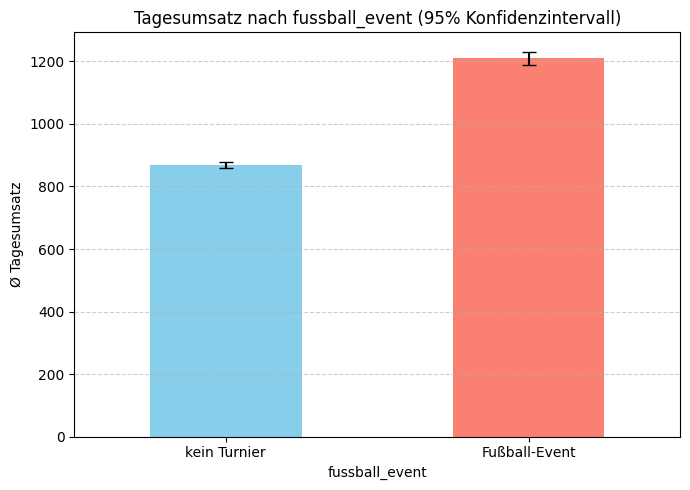

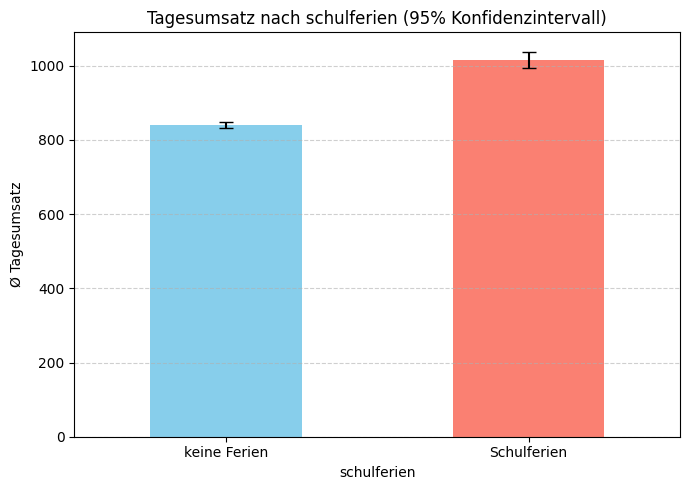

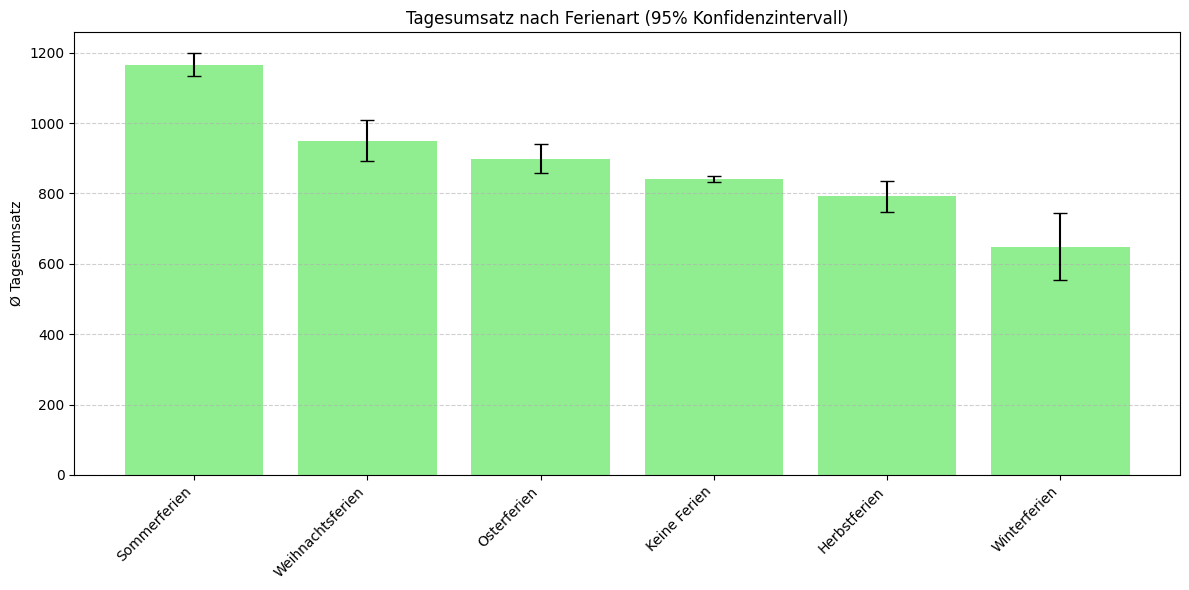

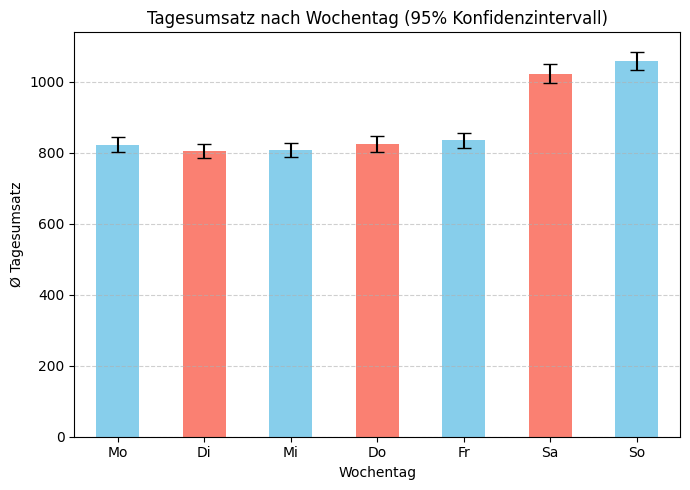

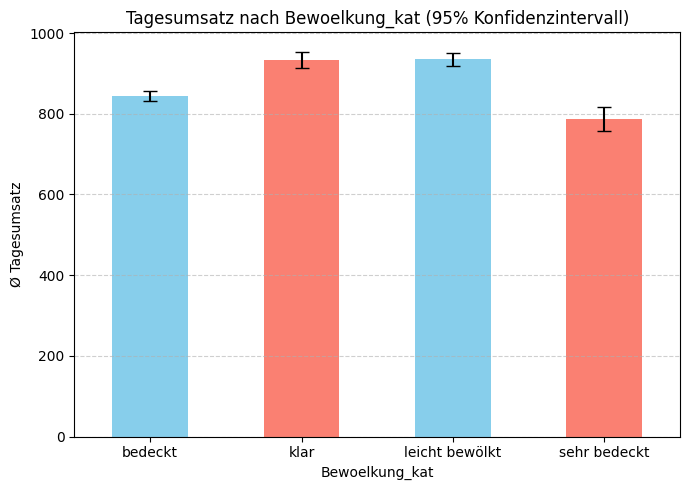

/tmp/ipykernel_12854/1993906236.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gruppen = merged_df.groupby(["Wochentag_label", "Warengruppe_label"])["Umsatz"]


<Figure size 1200x600 with 0 Axes>

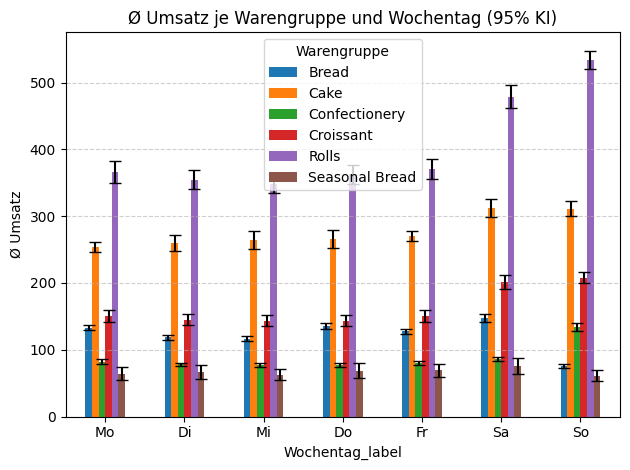

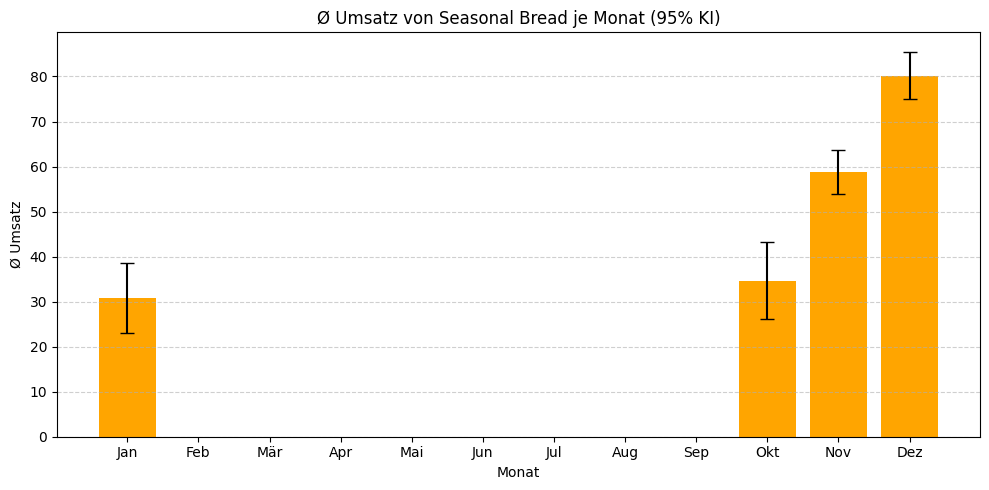

In [83]:
import matplotlib.pyplot as plt
from scipy import stats

def plot_balkendiagramm_mit_ki(df, var_name, label_map):
    gruppen = df.groupby(var_name)["sales_daily"]
    mittelwerte = gruppen.mean()
    standardfehler = gruppen.sem()
    konfidenz = standardfehler * stats.t.ppf(0.975, gruppen.count() - 1)

    # Plot
    plt.figure(figsize=(7, 5))
    mittelwerte.plot(kind="bar", yerr=konfidenz, capsize=5, color=["skyblue", "salmon"])
    plt.xticks(ticks=range(len(mittelwerte)), labels=[label_map[i] for i in mittelwerte.index], rotation=0)
    plt.ylabel("Ø Tagesumsatz")
    plt.title(f"Tagesumsatz nach {var_name} (95% Konfidenzintervall)")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot 1: Fußball-Events
plot_balkendiagramm_mit_ki(merged_df, "fussball_event", {0: "kein Turnier", 1: "Fußball-Event"})

# Plot 2: Schulferien
plot_balkendiagramm_mit_ki(merged_df, "schulferien", {0: "keine Ferien", 1: "Schulferien"})

import matplotlib.pyplot as plt
from scipy import stats

def plot_ferienvergleich(df, kategorien_col, wert_col="sales_daily"):
    gruppen = df.groupby(kategorien_col)[wert_col]
    mittelwerte = gruppen.mean()
    standardfehler = gruppen.sem()
    konfidenz = standardfehler * stats.t.ppf(0.975, gruppen.count() - 1)

    # Sortieren nach Mittelwert
    sort_idx = mittelwerte.sort_values(ascending=False).index
    mittelwerte = mittelwerte.loc[sort_idx]
    konfidenz = konfidenz.loc[sort_idx]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(mittelwerte.index, mittelwerte.values, yerr=konfidenz, capsize=5, color="lightgreen")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Ø Tagesumsatz")
    plt.title("Tagesumsatz nach Ferienart (95% Konfidenzintervall)")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot für Ferienarten
plot_ferienvergleich(merged_df, kategorien_col="ferientyp")

# Wochentag-Mapping (0 = Montag, ..., 6 = Sonntag)
wochentag_map = {
    0: "Mo", 1: "Di", 2: "Mi", 3: "Do",
    4: "Fr", 5: "Sa", 6: "So"
}

# Plot 3: Wochentage
plot_balkendiagramm_mit_ki(merged_df, "Wochentag", wochentag_map)

# Optional: Bewölkung in Kategorien unterteilen
def kategorisiere_bewoelkung(wert):
    if wert < 2:
        return "klar"
    elif wert < 6:
        return "leicht bewölkt"
    elif wert < 8:
        return "bedeckt"
    else:
        return "sehr bedeckt"

merged_df["Bewoelkung_kat"] = merged_df["Bewoelkung"].apply(kategorisiere_bewoelkung)

# Plot 4: Bewölkung
plot_balkendiagramm_mit_ki(
    merged_df,
    "Bewoelkung_kat",
    {"klar": "klar", "leicht bewölkt": "leicht bewölkt", "bedeckt": "bedeckt", "sehr bedeckt": "sehr bedeckt"}
)

import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Mapping für Wochentage und Warengruppen
wochentag_map = {0: "Mo", 1: "Di", 2: "Mi", 3: "Do", 4: "Fr", 5: "Sa", 6: "So"}
wochentag_order = ["Mo", "Di", "Mi", "Do", "Fr", "Sa", "So"]

warengruppe_map = {
    1: "Bread", 2: "Rolls", 3: "Croissant",
    4: "Confectionery", 5: "Cake", 6: "Seasonal Bread"
}

# Labels zuordnen
merged_df["Wochentag_label"] = pd.Categorical(
    merged_df["Wochentag"].map(wochentag_map),
    categories=wochentag_order, ordered=True
)
merged_df["Warengruppe_label"] = merged_df["Warengruppe"].map(warengruppe_map)

# Gruppieren
gruppen = merged_df.groupby(["Wochentag_label", "Warengruppe_label"])["Umsatz"]
mittelwerte = gruppen.mean().unstack()
standardfehler = gruppen.sem().unstack()
konfidenz = standardfehler * stats.t.ppf(0.975, gruppen.count().unstack().fillna(1) - 1)

# Plot
plt.figure(figsize=(12, 6))
mittelwerte.plot(kind="bar", yerr=konfidenz, capsize=4)
plt.ylabel("Ø Umsatz")
plt.title("Ø Umsatz je Warengruppe und Wochentag (95% KI)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title="Warengruppe")
plt.show()

import matplotlib.pyplot as plt
from scipy import stats

# Monatsnamen (für Achsenbeschriftung)
monatsnamen = ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", 
               "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"]

# Sicherstellen, dass Datum ein datetime ist
merged_df["Datum"] = pd.to_datetime(merged_df["Datum"])

# Filter: nur Warengruppe 6 (Seasonal Bread)
seasonal_df = merged_df[merged_df["Warengruppe"] == 6].copy()
seasonal_df["Monat"] = seasonal_df["Datum"].dt.month

# Gruppierung nach Monat
gruppen = seasonal_df.groupby("Monat")["Umsatz"]
mittelwerte = gruppen.mean()
standardfehler = gruppen.sem()
konfidenz = standardfehler * stats.t.ppf(0.975, gruppen.count() - 1)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(mittelwerte.index, mittelwerte.values, yerr=konfidenz, capsize=5, color="orange")
plt.xticks(ticks=range(1, 13), labels=monatsnamen)
plt.xlabel("Monat")
plt.ylabel("Ø Umsatz")
plt.title("Ø Umsatz von Seasonal Bread je Monat (95% KI)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [67]:
import pandas as pd
from datetime import datetime

# Load the merged dataset from the first script
merged_df = pd.read_csv("merged_output.csv")

# Convert Datum column to datetime if not already done
merged_df['Datum'] = pd.to_datetime(merged_df['Datum'])

# Define date ranges for splitting
train_start = datetime(2013, 7, 1)
train_end = datetime(2017, 7, 31)
val_start = datetime(2017, 8, 1)
val_end = datetime(2018, 7, 31)
test_start = datetime(2018, 8, 1)
test_end = datetime(2019, 7, 31)

# Split the dataset based on date ranges
train_set = merged_df[(merged_df['Datum'] >= train_start) & 
                      (merged_df['Datum'] <= train_end)].copy()

validation_set = merged_df[(merged_df['Datum'] >= val_start) & 
                          (merged_df['Datum'] <= val_end)].copy()

test_set = merged_df[(merged_df['Datum'] >= test_start) & 
                     (merged_df['Datum'] <= test_end)].copy()

# Save the split datasets
train_set.to_csv("train_set.csv", index=False)
validation_set.to_csv("validation_set.csv", index=False)
test_set.to_csv("test_set.csv", index=False)


VALIDIERUNG:
MSE: 4616.244061786269
R² : 0.7271671354944225
Adjusted R²: 0.7175


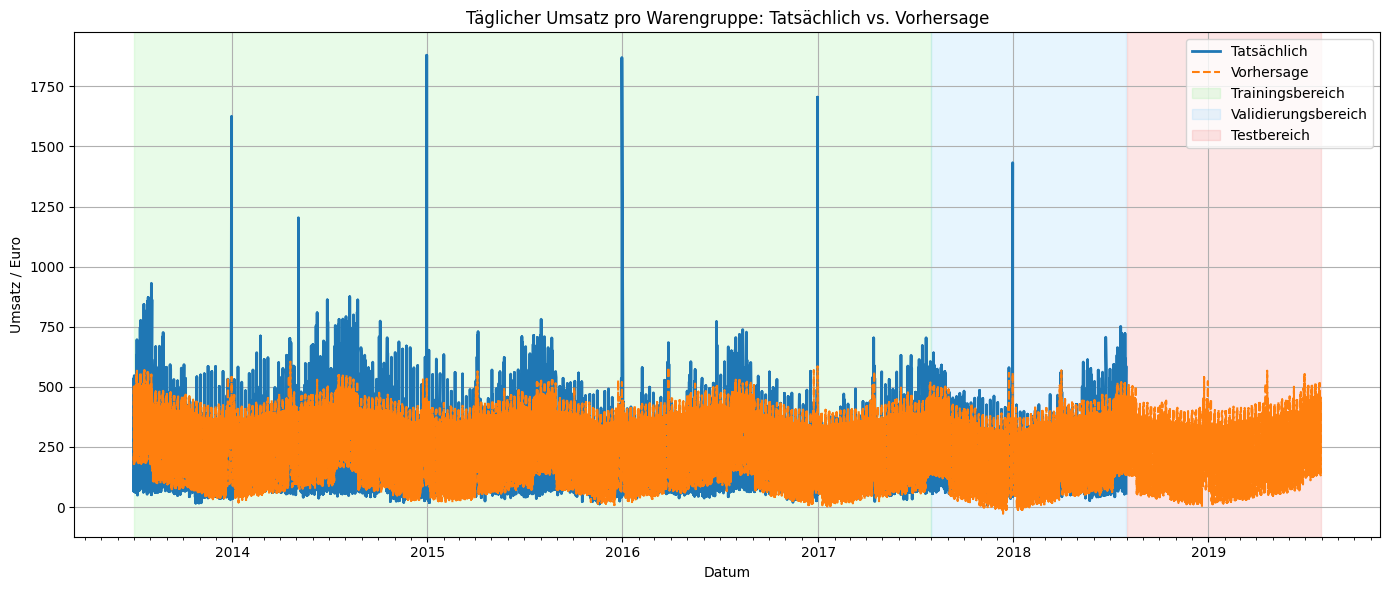

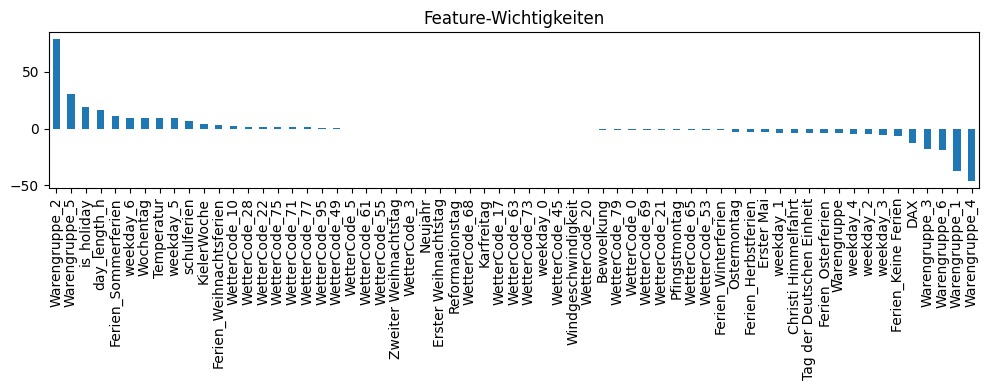

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# === DATEN EINLESEN ===
train_set = pd.read_csv("train_set.csv")
validation_set = pd.read_csv("validation_set.csv")
test_set = pd.read_csv("test_set.csv")
test_df = pd.read_csv("test.csv")  # Enthält IDs

# === FEATURE-SELEKTION ===
exclude_cols = [
    'Umsatz', 'fussball_event', 'ferientyp', 'id', 'Datum',
    'Feiertag', 'sales_daily', 'Wettercode'
]
feature_cols = [col for col in train_set.columns if col not in exclude_cols]
target_col = 'Umsatz'

# === FEATURES & TARGETS ===
X_train = train_set[feature_cols].fillna(0)
y_train = train_set[target_col]
X_val = validation_set[feature_cols].fillna(0)
y_val = validation_set[target_col]
X_test = test_set[feature_cols].fillna(0)
y_test = test_set[target_col]

# === SKALIERUNG ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# === MODELL ===
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# === BEWERTUNG ===
y_val_pred = model.predict(X_val_scaled)
print("\nVALIDIERUNG:")
print("MSE:", mean_squared_error(y_val, y_val_pred))
print("R² :", r2_score(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)
n, p = X_val.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R²: {adjusted_r2:.4f}")

# === VORHERSAGEN AN ALLE SETS ANHÄNGEN ===
train_set["Set"] = "Train"
validation_set["Set"] = "Validation"
test_set["Set"] = "Test"
train_set["Prediction"] = model.predict(X_train_scaled)
validation_set["Prediction"] = model.predict(X_val_scaled)
test_set["Prediction"] = model.predict(X_test_scaled)

# === GESAMTPLOT ===
full_df = pd.concat([train_set, validation_set, test_set], axis=0)
full_df["Datum"] = pd.to_datetime(full_df["Datum"])
full_df = full_df.sort_values("Datum")

plt.figure(figsize=(14, 6))
plt.plot(full_df["Datum"], full_df["Umsatz"], label="Tatsächlich", linewidth=2)
plt.plot(full_df["Datum"], full_df["Prediction"], label="Vorhersage", linestyle="--")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Zeitbereiche farblich markieren
for (start, end, color, label) in [
    (train_set["Datum"].min(), train_set["Datum"].max(), "lightgreen", "Trainingsbereich"),
    (validation_set["Datum"].min(), validation_set["Datum"].max(), "lightskyblue", "Validierungsbereich"),
    (test_set["Datum"].min(), test_set["Datum"].max(), "lightcoral", "Testbereich")
]:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=0.2, label=label)

plt.title("Täglicher Umsatz pro Warengruppe: Tatsächlich vs. Vorhersage")
plt.xlabel("Datum")
plt.ylabel("Umsatz / Euro")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === FEATURE-WICHTIGKEITEN ===
weights = pd.Series(model.coef_, index=feature_cols)
weights.sort_values(ascending=False).plot(kind="bar", figsize=(10, 4), title="Feature-Wichtigkeiten")
plt.tight_layout()
plt.show()

# === TEST-PREDICTIONS EXPORT FÜR KAGGLE ===
predictions = model.predict(X_test_scaled)

# Datum und Warengruppe sauber casten
test_set["Datum"] = pd.to_datetime(test_set["Datum"])
test_df["Datum"] = pd.to_datetime(test_df["Datum"])

# Prediction DataFrame
pred_df = pd.DataFrame({
    "Datum": test_set["Datum"],
    "Warengruppe": test_set["Warengruppe"],
    "Umsatz": predictions
})

# Merge über Datum + Warengruppe → final Submission
final_df = test_df[["id", "Datum", "Warengruppe"]].merge(
    pred_df, on=["Datum", "Warengruppe"], how="left"
)
final_df = final_df[["id", "Umsatz"]].rename(columns={"Umsatz": "sales_daily"})
final_df.to_csv("test_predictions.csv", index=False)


In [46]:
for feature, coef in zip(feature_cols, model.coef_):
    print(f"{feature} * {coef:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

from sklearn.metrics import r2_score



Umsatz * 147.7593
Bewoelkung * -0.0000
Temperatur * 0.0000
Windgeschwindigkeit * -0.0000
KielerWoche * -0.0000
WetterCode_0 * -0.0000
WetterCode_3 * 0.0000
WetterCode_5 * -0.0000
WetterCode_10 * -0.0000
WetterCode_17 * 0.0000
WetterCode_20 * 0.0000
WetterCode_21 * -0.0000
WetterCode_22 * -0.0000
WetterCode_28 * -0.0000
WetterCode_45 * -0.0000
WetterCode_49 * -0.0000
WetterCode_53 * 0.0000
WetterCode_55 * 0.0000
WetterCode_61 * 0.0000
WetterCode_63 * 0.0000
WetterCode_65 * 0.0000
WetterCode_68 * 0.0000
WetterCode_69 * 0.0000
WetterCode_71 * -0.0000
WetterCode_73 * -0.0000
WetterCode_75 * 0.0000
WetterCode_77 * -0.0000
WetterCode_79 * 0.0000
WetterCode_95 * 0.0000
is_holiday * 0.0000
Christi Himmelfahrt * 0.0000
Erster Mai * 0.0000
Erster Weihnachtstag * -0.0000
Karfreitag * -0.0000
Neujahr * -0.0000
Ostermontag * -0.0000
Pfingstmontag * 0.0000
Reformationstag * 0.0000
Tag der Deutschen Einheit * 0.0000
Zweiter Weihnachtstag * 0.0000
DAX * 0.0000
Wochentag * 0.0000
weekday_0 * 0.0000
wee